<a href="https://colab.research.google.com/github/victor-radermecker/Capstone_JPMorgan/blob/conv-lstm/Notebooks_toMerge/ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvLSTM Training on Dynamic World Dataset

`Author`: Andrea Zanon, Victor Radermecker

`Date`: July, 31st, 2023

# Package Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
# Import packages
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set preferences
tf.random.set_seed(42)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# update local libraries automatically
%load_ext autoreload
%autoreload 2

sys.path.append('/content/drive/MyDrive/Code/')
import SequenceDataLoader
from get_data_loader import get_data_loader

sys.path.append('/content/drive/MyDrive/Google Earth Exports/')

# Predicting Urbanization *Rate* Using Convolutional LSTMs

`Author:` Andrea Zanon, Victor Radermecker

`Date:` Tuesday, July 18th

In this Jupyter Notebook, we predict urbanization rate using a Convolution Long Short Term Memory model. The training data consists of Dynamic World labels, extracted using the Fishnet Class.

_Data Loading_:

A CSV of the following structure should be loaded to run the following model. This dataframe can be obtained using the `DataPreprocessing.ipynb` file from the package. Each .CSV dataset comes with a metadata .txt file, that contains useful information such as the number of rows and columns in the fishnet. These values are necessary to run this Notebook. The second cell below prints the information contains in the metadata file.

<table>
  <thead>
    <tr>
      <th>idx</th>
      <th>tile_id</th>
      <th>batch_id</th>
      <th>year</th>
      <th>urbanization_rate</th>
      <th>urbanization</th>
      <th>Lat</th>
      <th>Lon</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2017</td>
      <td>0.063333</td>
      <td>0.710556</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>1</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2018</td>
      <td>0.097778</td>
      <td>0.773889</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>2</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2019</td>
      <td>-0.010556</td>
      <td>0.871667</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>3</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2020</td>
      <td>0.025000</td>
      <td>0.861111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>4</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2021</td>
      <td>0.027778</td>
      <td>0.886111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
  </tbody>
</table>


In [3]:
TRAIN_PATH = '/content/drive/MyDrive/Code/Datasets/Train/urbanization_train.csv'
VAL_PATH = '/content/drive/MyDrive/Code/Datasets/Valid/urbanization_valid.csv'
TEST_PATH = '/content/drive/MyDrive/Code/Datasets/Test/urbanization_test.csv'

In [4]:
# train data, Texas region
train_data = pd.read_csv(TRAIN_PATH)

# validation data, Georgia region
val_data = pd.read_csv(VAL_PATH)

# test data, Ohio region
test_data = pd.read_csv(TEST_PATH)

# Filtering

In [6]:
def filter_data(data, threshold = 0):

  mean_urbanization_by_tile = data.groupby('tile_id')['urbanization'].mean()
  mask = data['tile_id'].map(mean_urbanization_by_tile) > threshold

  return data[mask], data[~mask]

In [8]:
# train
train_data_f, train_data_s = filter_data(train_data)

# validation
val_data_f, val_data_s = filter_data(val_data)

# test
test_data_f, test_data_s = filter_data(test_data)

# Generate the data loader

Only five filtered data as input (train_data_f, val_data_f, test_data_f)

In [11]:
IMG_DIR_TRAIN = '/content/drive/MyDrive/Google Earth Exports/Train/'
IMG_DIR_VALID = '/content/drive/MyDrive/Google Earth Exports/Valid/'
IMG_DIR_TEST = '/content/drive/MyDrive/Google Earth Exports/Test/'

IMG_SIZE = (40, 44)
BATCH_SIZE = 128
N_CHANNELS = 1
LABELS = [2016, 2017, 2018, 2019, 2020, 2021]

In [10]:
def generate_tab_data(data):

  data_wide = data.pivot_table(index='tile_id', columns='year', values='urbanization', aggfunc='first')
  data_wide = data_wide.merge(right=data[['tile_id', 'Lat', 'Lon']], on='tile_id')
  data_wide.drop_duplicates(inplace = True, ignore_index = True)
  tab_data = data_wide.drop(columns = ["tile_id", 2022]).to_dict(orient='index')

  return tab_data


## `Training`

In [ ]:
train_tab_data = generate_tab_data(train_data)
train_data_loader = get_data_loader(train_data_f, IMG_DIR_TRAIN, IMG_SIZE, BATCH_SIZE, LABELS, N_CHANNELS, SHUFFLE = False) # keep order

## `Validation`

In [14]:
val_tab_data = generate_tab_data(val_data)
val_data_loader = get_data_loader(val_data_f, IMG_DIR_VALID, IMG_SIZE, BATCH_SIZE, LABELS, N_CHANNELS, SHUFFLE = False)

100%|██████████| 180984/180984 [00:16<00:00, 10666.58it/s]


Success. Completed creating batches.


## `Test`

In [15]:
test_tab_data = generate_tab_data(test_data)
test_data_loader = get_data_loader(test_data_f, IMG_DIR_TEST, IMG_SIZE, BATCH_SIZE, LABELS, N_CHANNELS, SHUFFLE = False)

100%|██████████| 159133/159133 [00:08<00:00, 17834.24it/s]


Success. Completed creating batches.


# Visualize the dataset

In [16]:
X, y = test_data_loader[-1]
print(X[0].shape)
print(X[1].shape)
print(y.shape)

(6, 40, 44, 1)
(6, 40, 44, 1)
(29,)


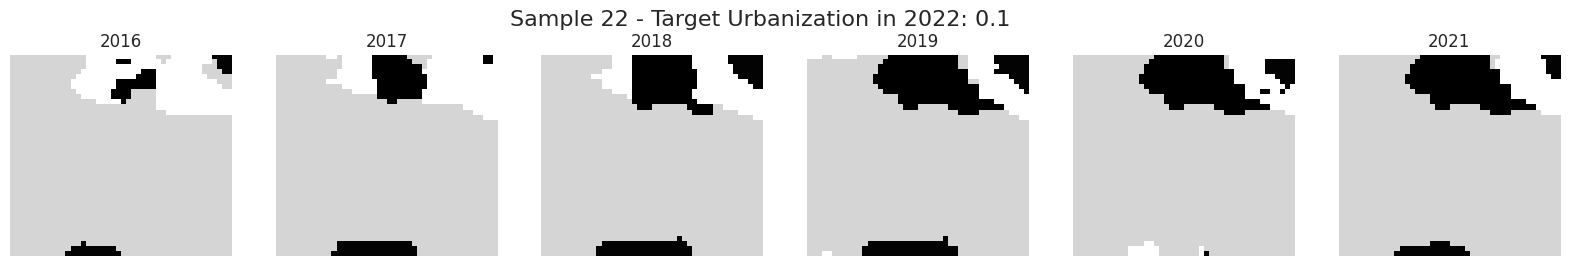

In [27]:
idx = np.random.randint(0, X.shape[0])
fig, axs = plt.subplots(1, len(LABELS), figsize=(20, 3))
fig.suptitle('Sample ' + str(idx) + f" - Target Urbanization in 2022: {y[idx]}", fontsize=16)

for i in range(len(LABELS)):
    axs[i].imshow(X[idx, i, :, :, :], cmap='gray')
    axs[i].set_title(LABELS[i])
    axs[i].axis('off')
plt.show()